In [1]:
import pickle
import matplotlib.pyplot as plt
import igraph as ig
import os
from tqdm import tqdm
import numpy as np
import random

In [2]:
# Matplotlib defaults

font = {"family" : "normal",
    "size" : 22}

plt.style.use("default")

plt.rcParams.update({"font.size" : 22})

# Analyze fragment diversity

Do fragments change as MA increases?

## Test 1: number of fragments over time

In [3]:
def build_month_increments(start, stop):
    """ Build all monthly increments from the start year to stop year in the
    format YEAR-MONTH

    Args:
        start (int): start year of increments
        stop (int): end year of increments

    Returns:
        list: list of strings holding the YEAR-MONTH increments
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

In [4]:
""" NewFrags holds fragments within the new compound sample, 
    while FullFrags is for fragments in the full database sample (regardless of naming files
    within it "newFrags", that was a file output error)
"""

def get_monthly_frags(month):
    return pickle.load(file=open("Data/AssemblyValues/Fragments/fullFrags_" + month + ".p", "rb"))

def get_monthly_fragCount(month):
    return pickle.load(file=open("Data/AssemblyValues/Fragments/fullFragsCount_" + month + ".p", "rb"))


In [5]:
def build_fragments(start, stop):
    months = build_month_increments(start, stop)
    frags = []
    frag_count = []

    for month in months:
        frags.append(get_monthly_frags(month))
        frag_count.append(get_monthly_fragCount(month))
        
    return frags, frag_count

In [7]:
# #Graph number of fragments over time
# sizes = []
# for month_frags in tqdm(frags):
#     sizes.append(len(month_frags))

NameError: name 'frags' is not defined

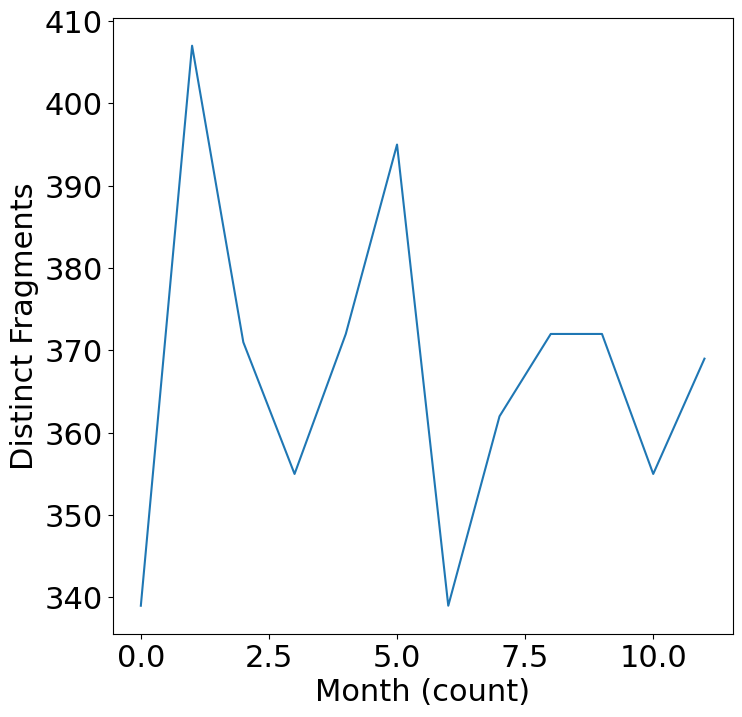

In [100]:
#     """ General thought - small increase, but not definitive
#     """

# plt.figure(figsize=(8,8))

# plt.plot(sizes)

# plt.xlabel("Month (count)")
# plt.ylabel("Distinct Fragments")

# plt.show()

## Step 2: different _types_ of fragments

Are there increasing numbers of different types (aka those not seen before) as time increases?

In [8]:
# ## Get a master list of fragments (starting with Jan 1976)

# all_frags = frags[0] #1976-01 fragments
# all_fragCounts = frag_count[0]

# print(len(all_frags))
# print(len(all_fragCounts))
# print(all_frags)
# print("---")
# print(all_fragCounts)

NameError: name 'frags' is not defined

In [7]:
## Testing: find new fragments in 1980-02, and count the number of additions

def novel_frag_analysis(start, stop, frags, frag_count):
    
    months = build_month_increments(start, stop)
    novel_frag_count = [] #Novel fragments (never-before-seen) per month
    all_unique_frags = frags[0] #List of all unique fragments - starting with 1st month
    unique_frag_count_per_month = frag_count[0] #Counts of each unique fragment, per month
    total_frag_counts_copy_number = []

    frag_count_total = {} #Total counts of each unique fragment - using id:[counts per month] as data structure
    for id, count in unique_frag_count_per_month.items():
        frag_count_total[id] = [count]


    #Loop through every month...
    for i in tqdm(range(1, len(frags))):
        novel_frags = 0 #Number of new fragments in a given month
        current_allfrags_size = len(all_unique_frags) #Current cumulative of  unique fragments
        unique_frag_count_per_month = frag_count[i] #Find counts of each fragment found per month
        repeat_indicies = [] #Indicies of all repeat fragments
        
        #Find the total number of fragments, with copy number
        copy_number = 0
        for id, count in frag_count[i].items():
            copy_number += count
        total_frag_counts_copy_number.append(copy_number)

        #Test all monthly fragments...
        for j in range(len(frags[i])): #candidate_f in frags[i]:

            is_unique = True

            #...against all unique fragments...
            for k in range(len(all_unique_frags[:current_allfrags_size])):
                if frags[i][j].isomorphic_vf2(all_unique_frags[k],
                                                color1=frags[i][j].vs["color"],
                                                color2=all_unique_frags[k].vs["color"],
                                                edge_color1=frags[i][j].es["color"],
                                                edge_color2=all_unique_frags[k].es["color"]):
                    #...if candidate is isomorphic, it is not unique, therefore break off check...
                    is_unique = False
                    if not is_unique:
                        repeat_indicies.append(k)
                    break

            #...if it makes it through the full list of fragments, it is unique!
            if is_unique:
                all_unique_frags.append(frags[i][j])
                novel_frags += 1

                #Add 0s in front of total counts to represent months where this was not found
                # (will use this for dates as well)
                frag_count_total[len(frag_count_total)] = [0]*i + [unique_frag_count_per_month[j]]

            else:
                ## Add to count (using k as the marker for which unique fragment was counted)
                frag_count_total[k].append(unique_frag_count_per_month[j])

        #Add zeros to the counts which were not found in the isomorphic check
        for l in range(len(frag_count_total)):
            #Those not in the check are those that: 1) were not repeated,
            # and 2) were not unique (already existed within the dataset)
            if l not in repeat_indicies and l < current_allfrags_size:
                frag_count_total[l].append(0)

        novel_frag_count.append(novel_frags)

    cum_frag_count = np.cumsum(novel_frag_count)
    
    return novel_frag_count, all_unique_frags, frag_count_total, cum_frag_count, total_frag_counts_copy_number

In [8]:
start = 1976
stop = 2022

print("--- Ordered --- ")
frags, frag_count = build_fragments(start, stop)
novel_frag_count, all_unique_frags, frag_count_total, cum_frag_count, total_frag_counts_copy_number = novel_frag_analysis(start, stop, frags, frag_count)

print("--- Reversed --- ")
frags, frag_count = build_fragments(start, stop)
frags.reverse()
frag_count.reverse()

novel_frag_count_R, all_unique_frags_R, frag_count_total_R, cum_frag_count_R, total_frag_counts_copy_number_R = novel_frag_analysis(start, stop, frags, frag_count)

print("--- Mixed --- ")
frags, frag_count = build_fragments(start, stop)
c = list(zip(frags, frag_count))
random.shuffle(c)
frags, frag_count = zip(*c)

novel_frag_count_M, all_unique_frags_M, frag_count_total_M, cum_frag_count_M, total_frag_counts_copy_number_M = novel_frag_analysis(start, stop, frags, frag_count)

--- Ordered --- 


100%|███████████████████████████████████████| 563/563 [1:49:04<00:00, 11.62s/it]


--- Reversed --- 


100%|███████████████████████████████████████| 563/563 [1:45:12<00:00, 11.21s/it]


--- Mixed --- 


100%|███████████████████████████████████████| 563/563 [1:42:32<00:00, 10.93s/it]


In [10]:
## Dump Ordered results
pickle.dump(novel_frag_count, file=open("Data/AssemblyValues/Fragments/Ordered/novel_frag_count.p", "wb"))
pickle.dump(all_unique_frags, file=open("Data/AssemblyValues/Fragments/Ordered/all_unique_frags.p", "wb"))
pickle.dump(frag_count_total, file=open("Data/AssemblyValues/Fragments/Ordered/frag_count_total.p", "wb"))
pickle.dump(cum_frag_count, file=open("Data/AssemblyValues/Fragments/Ordered/cum_frag_count.p", "wb"))
pickle.dump(total_frag_counts_copy_number, file=open("Data/AssemblyValues/Fragments/Ordered/total_frag_counts_copy_number.p", "wb"))

In [11]:
## Dump Reversed results
pickle.dump(novel_frag_count_R, file=open("Data/AssemblyValues/Fragments/Reversed/novel_frag_count_R.p", "wb"))
pickle.dump(all_unique_frags_R, file=open("Data/AssemblyValues/Fragments/Reversed/all_unique_frags_R.p", "wb"))
pickle.dump(frag_count_total_R, file=open("Data/AssemblyValues/Fragments/Reversed/frag_count_total_R.p", "wb"))
pickle.dump(cum_frag_count_R, file=open("Data/AssemblyValues/Fragments/Reversed/cum_frag_count_R.p", "wb"))
pickle.dump(total_frag_counts_copy_number_R, file=open("Data/AssemblyValues/Fragments/Reversed/total_frag_counts_copy_number_R.p", "wb"))

In [12]:
## Dump Mixed results
pickle.dump(novel_frag_count_M, file=open("Data/AssemblyValues/Fragments/Mixed/novel_frag_count_M.p", "wb"))
pickle.dump(all_unique_frags_M, file=open("Data/AssemblyValues/Fragments/Mixed/all_unique_frags_M.p", "wb"))
pickle.dump(frag_count_total_M, file=open("Data/AssemblyValues/Fragments/Mixed/frag_count_total_M.p", "wb"))
pickle.dump(cum_frag_count_M, file=open("Data/AssemblyValues/Fragments/Mixed/cum_frag_count_M.p", "wb"))
pickle.dump(total_frag_counts_copy_number_M, file=open("Data/AssemblyValues/Fragments/Mixed/total_frag_counts_copy_number_M.p", "wb"))

In [11]:
print("Novel Frag Count:", novel_frag_count)
print("\n----\n")
print("All Unique Frags:", all_unique_frags)
print("\n----\n")
print("Frag Count Total:", frag_count_total)
print("\n----\n")
print("Total Frag Count Copy Number:", total_frag_counts_copy_number)

Novel Frag Count: [210, 166, 154, 154, 141, 139, 127, 125, 130, 131, 113, 108, 87, 100, 90, 110, 105, 110, 102, 64, 83, 103, 98]

----

All Unique Frags: [<igraph.Graph object at 0x130270a90>, <igraph.Graph object at 0x130270b80>, <igraph.Graph object at 0x130270310>, <igraph.Graph object at 0x130270c70>, <igraph.Graph object at 0x130270d60>, <igraph.Graph object at 0x130270e50>, <igraph.Graph object at 0x130344040>, <igraph.Graph object at 0x130344130>, <igraph.Graph object at 0x130344310>, <igraph.Graph object at 0x130344400>, <igraph.Graph object at 0x1303444f0>, <igraph.Graph object at 0x1303445e0>, <igraph.Graph object at 0x1303446d0>, <igraph.Graph object at 0x1303447c0>, <igraph.Graph object at 0x1303448b0>, <igraph.Graph object at 0x1303449a0>, <igraph.Graph object at 0x130344a90>, <igraph.Graph object at 0x130344220>, <igraph.Graph object at 0x130344b80>, <igraph.Graph object at 0x130344c70>, <igraph.Graph object at 0x130344d60>, <igraph.Graph object at 0x130344e50>, <igraph.G

In [12]:
###  Testing to make sure all counts are the same
for date, total in frag_count_total.items():
    if (len(total)) != 24:
        print("AHHHH")

## Unique Frags as a Function of Total Frags

Log(total) on the x-axis, log(unique) on y-axis

Text(0.5, 1.0, '1976 - 2022')

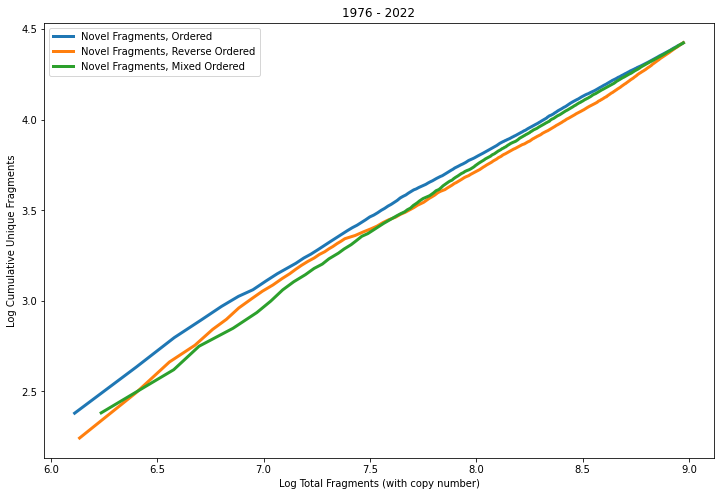

In [13]:
plt.figure(figsize=(12,8))

plt.plot(np.log10(np.cumsum(total_frag_counts_copy_number)), np.log10(cum_frag_count), 
         linewidth=3, label="Novel Fragments, Ordered")
plt.plot(np.log10(np.cumsum(total_frag_counts_copy_number_R)), np.log10(cum_frag_count_R), 
         linewidth=3, label="Novel Fragments, Reverse Ordered")
plt.plot(np.log10(np.cumsum(total_frag_counts_copy_number_M)), np.log10(cum_frag_count_M), 
         linewidth=3, label="Novel Fragments, Mixed Ordered")


plt.ylabel("Log Cumulative Unique Fragments")
plt.xlabel("Log Total Fragments (with copy number)")

plt.legend()
plt.title(str(start) + " - " + str(stop))

Text(0.5, 1.0, '1976 - 2022')

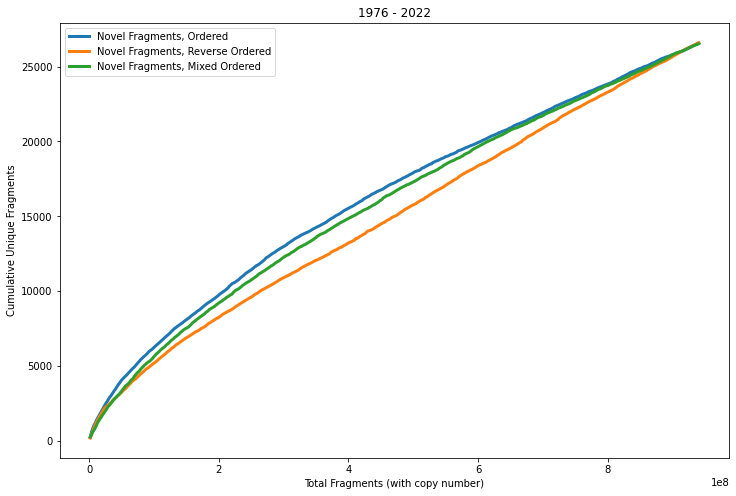

In [14]:
plt.figure(figsize=(12,8))

plt.plot(np.cumsum(total_frag_counts_copy_number), cum_frag_count, 
         linewidth=3, label="Novel Fragments, Ordered")
plt.plot(np.cumsum(total_frag_counts_copy_number_R), cum_frag_count_R, 
         linewidth=3, label="Novel Fragments, Reverse Ordered")
plt.plot(np.cumsum(total_frag_counts_copy_number_M), cum_frag_count_M, 
         linewidth=3, label="Novel Fragments, Mixed Ordered")


plt.ylabel("Cumulative Unique Fragments")
plt.xlabel("Total Fragments (with copy number)")

plt.legend()
plt.title(str(start) + " - " + str(stop))

## Novel Fragments over time

Counts of new fragments per month

Text(0, 0.5, 'Novel Fragments')

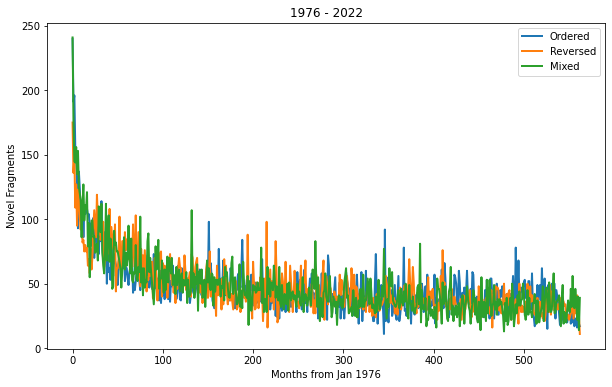

In [15]:
plt.figure(figsize=(10,6))

plt.plot(novel_frag_count, linewidth=2, label="Ordered")
plt.plot(novel_frag_count_R, linewidth=2, label="Reversed")
plt.plot(novel_frag_count_M, linewidth=2, label="Mixed")

plt.legend()
plt.title(str(start) + " - " + str(stop))
plt.xlabel("Months from Jan " +  str(start))
plt.ylabel("Novel Fragments")

## Fragment copy number distribution

Distribution (per month) of fragment counts, which include how often each fragment is used (copy number)

Also includes cumulative counts of each fragment

The full distributions would be the same regardless of reverse/mixed, since they come from the same data source

In [26]:
print(list(frag_count_total.items())[0:5])
print(len(frags))

[(0, [11639, 4594, 2091, 1392, 4659, 3049, 2365, 2818, 6502, 8263, 2625, 5789, 6661, 6250, 4912, 1679, 1931, 2672, 1061, 2002, 1191, 3867, 2304, 0]), (1, [3671, 3985, 4602, 4450, 3794, 4061, 4412, 1342, 2676, 6526, 3366, 2072, 7954, 6707, 3141, 3486, 2131, 4942, 5965, 2740, 3582, 5933, 2435, 3146]), (2, [207804, 199095, 198771, 179606, 187642, 203430, 231434, 209043, 204790, 222494, 225953, 180259, 257158, 176140, 189383, 225895, 200703, 193505, 212081, 192543, 237349, 182988, 209188, 199231]), (3, [406730, 417923, 325126, 409792, 405555, 443246, 390956, 443147, 440308, 399290, 372015, 389913, 389349, 392450, 446259, 440081, 361841, 431783, 411315, 445570, 332159, 378420, 414590, 424862]), (4, [4348, 7936, 12433, 4999, 8135, 3095, 7776, 3871, 7951, 4824, 5068, 2995, 2812, 5000, 7824, 3287, 9653, 3203, 2924, 4830, 4218, 2579, 4956, 3226])]
24


In [36]:
def get_frag_counts(frag_count_totals, i):
    """ Gets individual monthly counts of fragments (e.g., returns the 0th values from every fragment count)
    
    Inputs: 
        frag_count_totals (dict): dictionary of fragment ids & counts per month {id: [x, y, z...]}
        i (int) = index of counts to return (e.g., i=0 would return x)
        
    Returns:
        list: values corresponding to the ith value in counts
    """
    frag_counts_i = []
    for id, counts in frag_count_totals.items():
        frag_counts_i.append(counts[i])
        
    frag_counts_i.sort(reverse=True)
    
    return frag_counts_i

In [51]:
## Find total fragment counts every month for all runs
monthly_frag_counts = {}

for i in range(len(frags)):
    monthly_frag_counts[i] = get_frag_counts(frag_count_total, i)
    
## Find fragment counts across all months - this is the total number of times a fragment is found in the data set
all_frag_counts = []
for id, counts in frag_count_total.items():
    all_frag_counts.append(sum(counts))
    
all_frag_counts.sort(reverse=True)

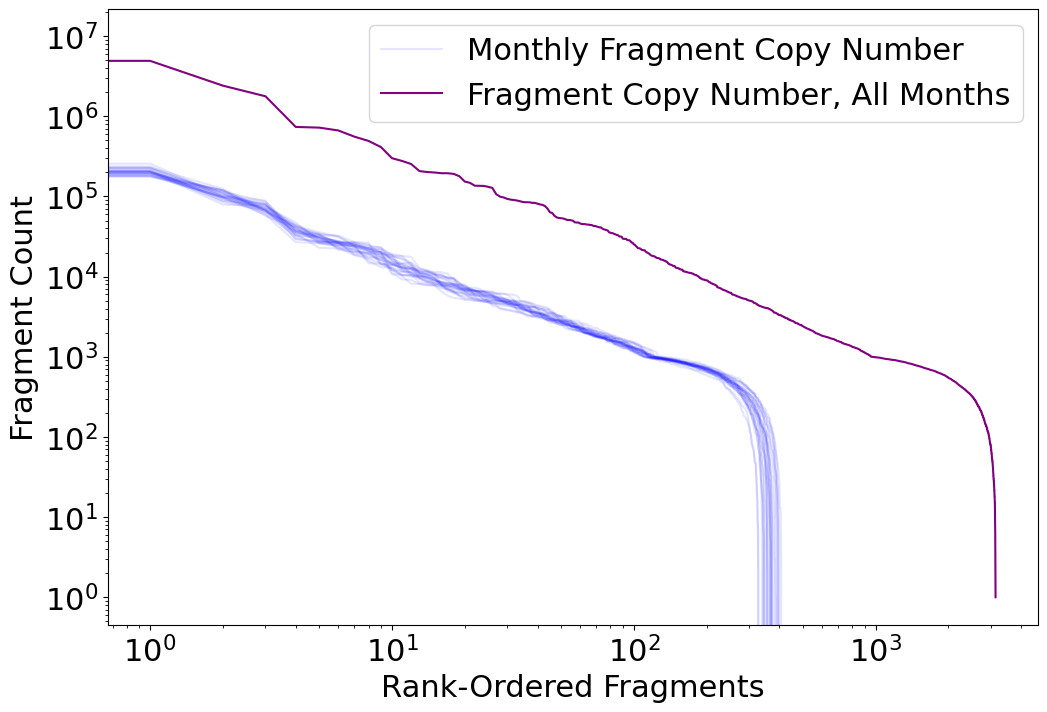

In [56]:
plt.figure(figsize=(12,8))

for i in range(len(frags)):
    if i == 0:
        plt.plot(monthly_frag_counts[i], color="blue", alpha=0.1, label="Monthly Fragment Copy Number")
    else:
        plt.plot(monthly_frag_counts[i], color="blue", alpha=0.1)
    
plt.plot(all_frag_counts, color="purple", label="Fragment Copy Number, All Months")
    
plt.xlabel("Rank-Ordered Fragments")
plt.ylabel("Fragment Count")
plt.legend()

plt.xscale("log")
plt.yscale("log")

**NEXT STEPS**

- Frequency of fragments as a function of number of bonds
- Relative frequency (copy number per fragment / total fragment count) of each fragment over the time series
- Cross-correlation of each fragment to each other (see Daniel's paper on pigeons)

Cross-correlation can build a directed graph showing influence (possibly causation) of fragments on each other, can be done by calculating correlations with time-shifts, then choosing a threshold correlation that builds the the optimally connected directed graph


- 

In [64]:
print(all_unique_frags[-1])
print(all_unique_frags[-1].vs["color"])
print(all_unique_frags[-1].es["color"])


IGRAPH U--- 10 10 --
+ attr: color (v), color (e)
+ edges:
0--1 2--3 4--5 1--4 6--7 1--6 3--5 3--7 3--8 8--9
[1, 1, 1, 1, 1, 1, 1, 1, 4, 4]
[1, 1, 2, 1, 1, 2, 1, 1, 1, 1]
